In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
def testscore(predtmp,oritmp):
    score=1
    pred=np.ravel(predtmp)
    ori=np.ravel(oritmp)
    if(len(pred)!=len(ori)):
        print('len not match')
        return 1
    n=0
    for i in range(len(pred)):
        if ori[i]!=0:
            n=n+1
    #print(n)
    for i in range(len(pred)):
        if ori[i]!=0:
            score=score-1/n*abs(pred[i]-ori[i])/abs(ori[i])
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('score:')
    print(score)
    return score

In [3]:

file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
#
x=np.array(x)
y=np.array(y)
vx=np.array(vx)
vy=np.array(vy)
isvalid=np.array(isvalid)

x=x.T
y=y.T
vx=vx.T
vy=vy.T
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=0.00002

t=t[80:120]
print(len(t))
t_train=np.linspace(t[0],t[-1],len(t)*2-1)
dt_train=t_train[1]-t_train[0]
print(t_train.shape)

40
(79,)


In [4]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=25

u=np.zeros((n,n,121, 2))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u_train=np.zeros((n,n,len(t_train), 2))
save=np.zeros((n,n,len(t_train), 2))
u_train=u[:,:,80:120,:]
save=u[:,:,80:120,:]

v_train=np.zeros((n,n,len(t_train),2))
for i in range(len(t)-1):
    v_train[:,:,2*i]=u_train[:,:,i]
    v_train[:,:,2*i+1]=(u_train[:,:,i]+u_train[:,:,i+1])/2
v_train[:,:,-1]=u_train[:,:,-1]


In [5]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
testscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
testscore(vtmp,v_train)

score:
-0.025083480228928926
score:
0.3215287580077763


0.3215287580077763

In [6]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.
library_functions = [
    lambda y: y,
    lambda x: x * x * x,

    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x + x + x,

    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('v_train')
print(v_train.shape)

'''
print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_train)

'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(v_train, dt_train)
model.print()
'''
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, t=dt)
model.print()


print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()'''

v_train
(25, 25, 79, 2)
STLSQ model: 
(Vx)' = 157.367 1 + 2.431 Vx + 61.298 Vy + 0.738 VxVxVx + -0.014 VyVyVy + -0.187 VxVyVy + -0.571 VxVxVy + 258.556 Vx_2 + 85.189 Vy_2 + 130.111 Vx_22 + 243.434 Vy_22 + 133.896 Vx_222 + -16.214 Vy_222 + 157.588 Vx_1 + -190.803 Vy_1 + 173.775 Vx_12 + -87.430 Vy_12 + 420.468 Vx_122 + -980.002 Vy_122 + 75.127 Vx_11 + -88.982 Vy_11 + 949.582 Vx_112 + 246.397 Vy_112 + 5.277 Vx_111 + -43.988 Vy_111 + -14.423 VxVx_2 + -303.573 VxVy_2 + 0.432 VyVx_2 + 0.434 VyVy_2 + 0.248 VxVxVxVx_2 + 1.814 VxVxVxVy_2 + 260.809 VyVyVyVx_2 + 67.744 VyVyVyVy_2 + -1.222 VxVyVyVx_2 + -0.249 VxVyVyVy_2 + -0.595 VxVxVyVx_2 + 0.566 VxVxVyVy_2 + -19.027 VxVx_22 + 2.000 VxVy_22 + -0.188 VyVx_22 + 0.254 VyVy_22 + 0.091 VxVxVxVx_22 + -0.409 VxVxVxVy_22 + 84.499 VyVyVyVx_22 + -33.240 VyVyVyVy_22 + -1.130 VxVyVyVx_22 + 0.325 VxVyVyVy_22 + -0.428 VxVxVyVx_22 + -1.330 VxVxVyVy_22 + 128.832 VxVx_222 + -581.929 VxVy_222 + 1.421 VyVx_222 + -2.417 VyVy_222 + -8.630 VxVxVxVx_222 + 5.110 VxVxVxV

"\nprint('SR3 model, L0 norm: ')\noptimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,\n                   thresholder='l0', normalize_columns=True)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])\nmodel.fit(u_train, t=dt)\nmodel.print()\n\n\nprint('SR3 model, L1 norm: ')\noptimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,\n                   thresholder='l1', normalize_columns=True)\n\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)\nmodel.fit(u_train, x_dot=u_dot_train)\nmodel.print()"

In [7]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: 0.037793
Model score: -0.002276
Model score: 0.026418
Model score: 0.026418


In [8]:
x_dot_test_predicted = model.predict(v_train)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))


In [9]:
pltpredict=v_train+dot_tmp*dt_train
pltpredict[:,:,1:]=pltpredict[:,:,:len(t_train)-1]
testscore(pltpredict,v_train)


score:
-0.3892093222726136


-0.3892093222726136

0


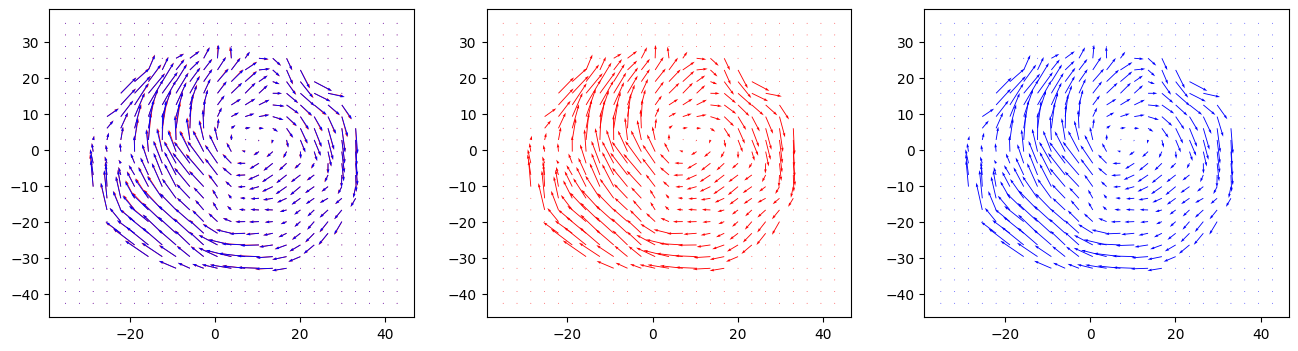

score:
0.7470561819069705
1


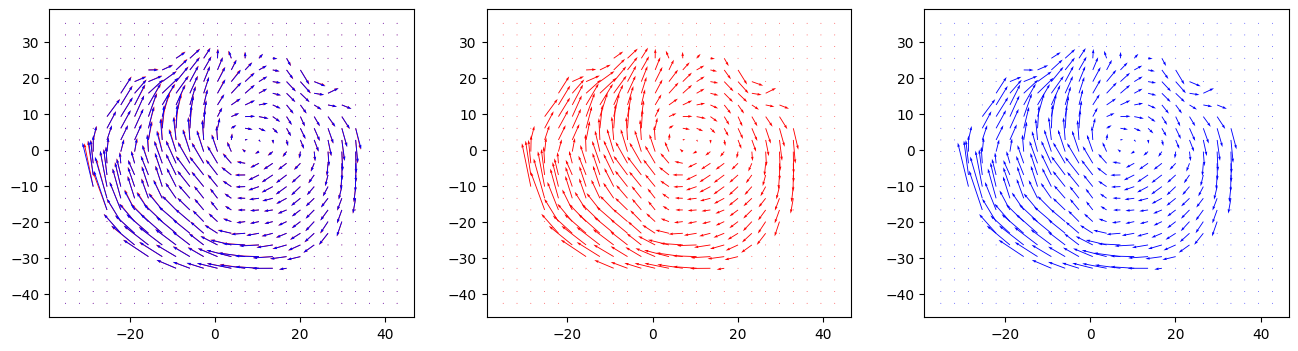

score:
0.692347143002992
2


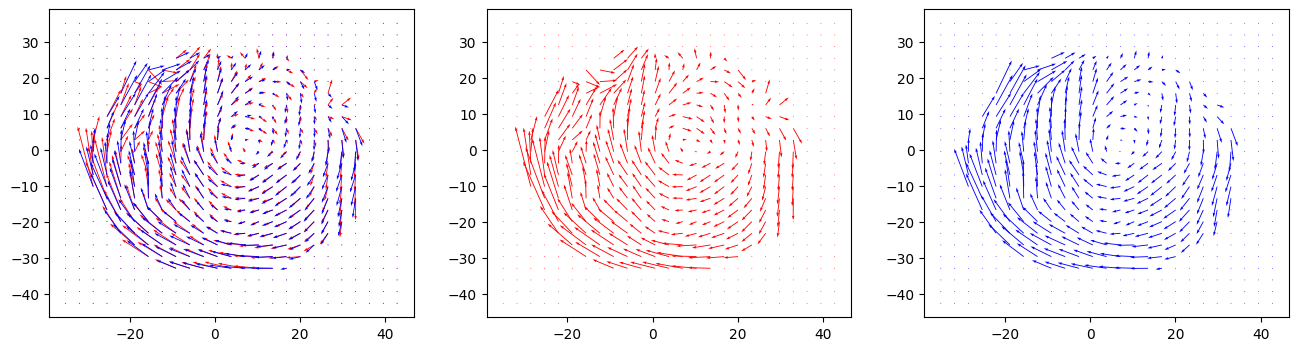

score:
-1.2187846210513482
3


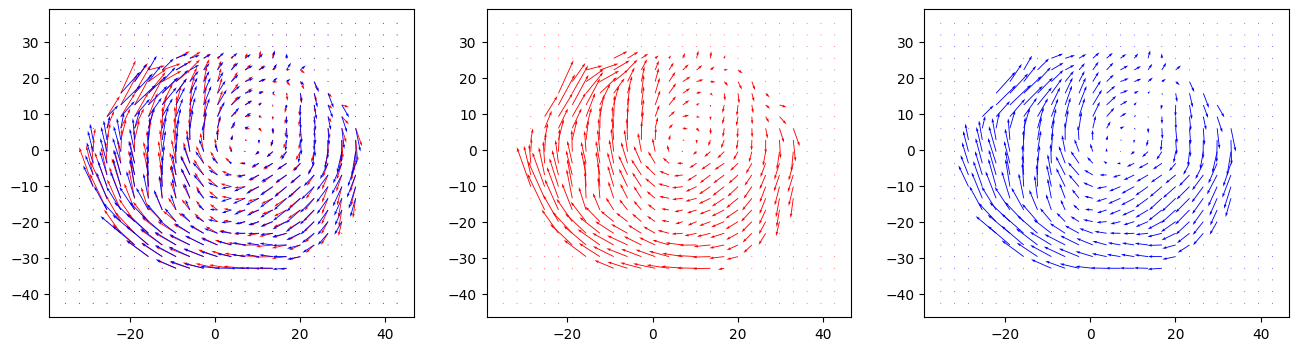

score:
0.05718887964795966
4


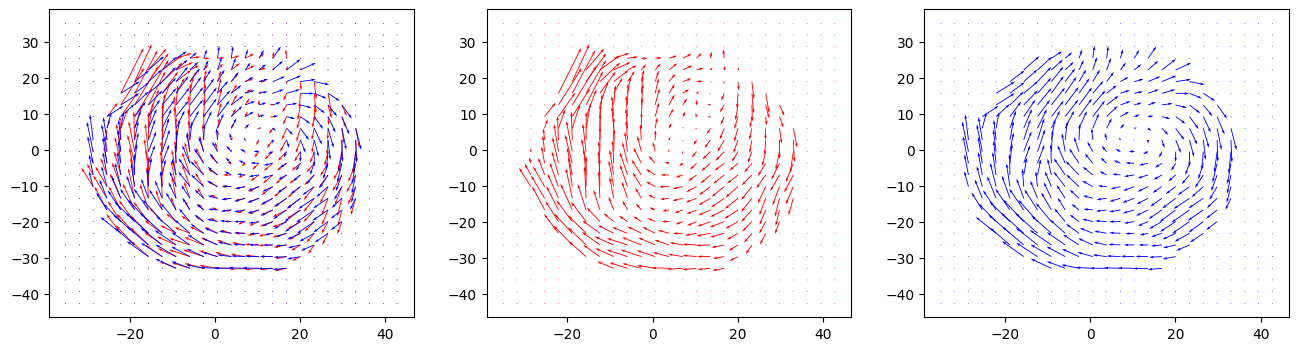

score:
-2.7260976848209006
5


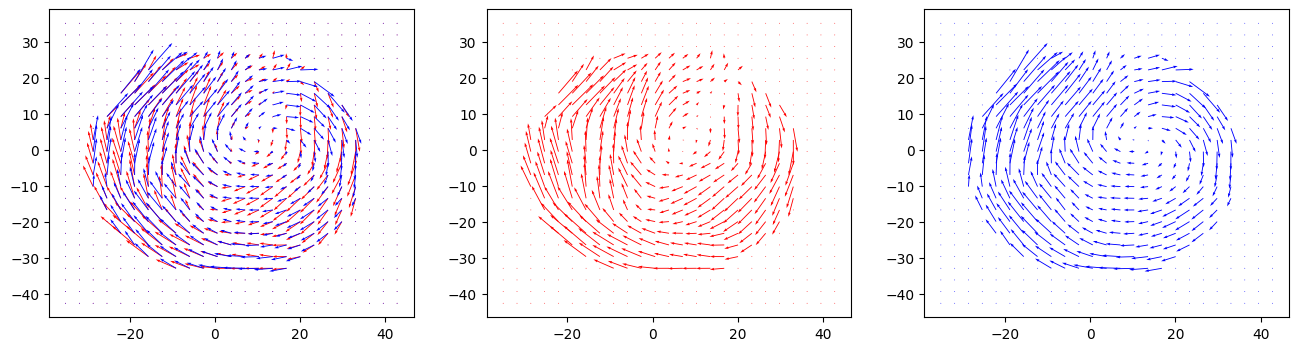

score:
-1.3100859236692548
6


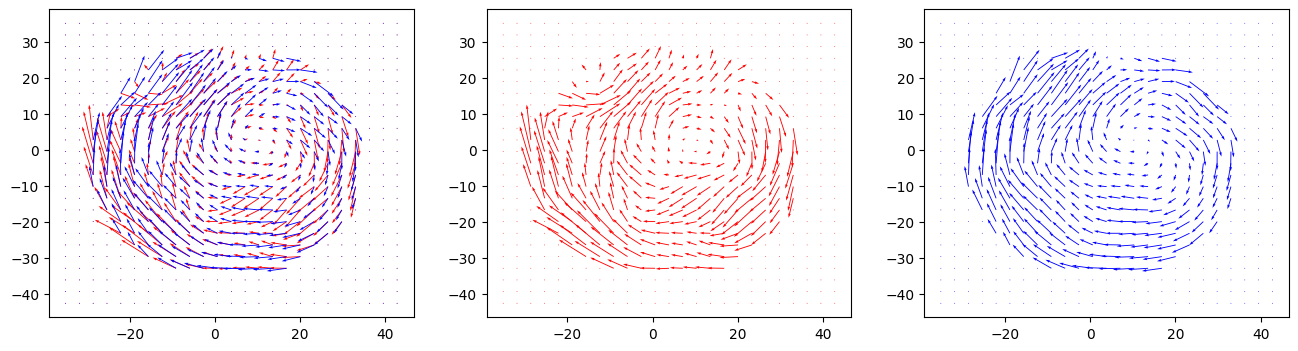

score:
-0.5605893516123761
7


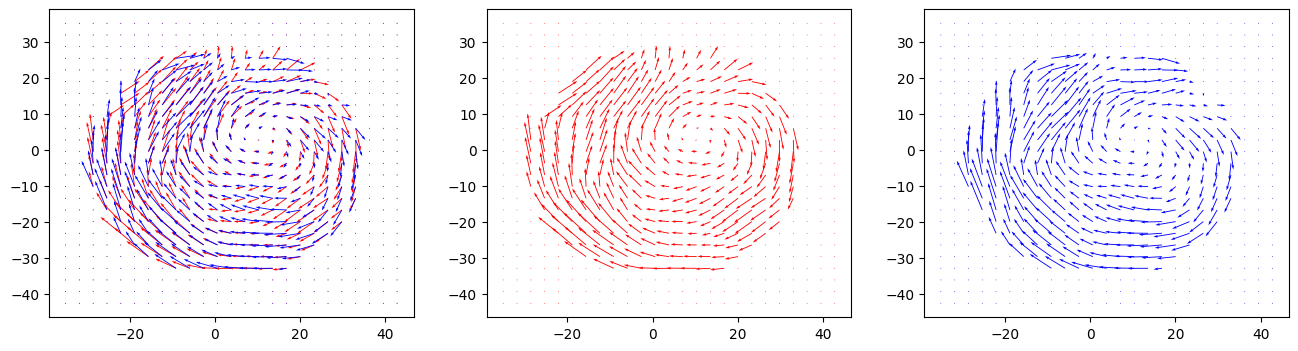

score:
0.011245968983614667
8


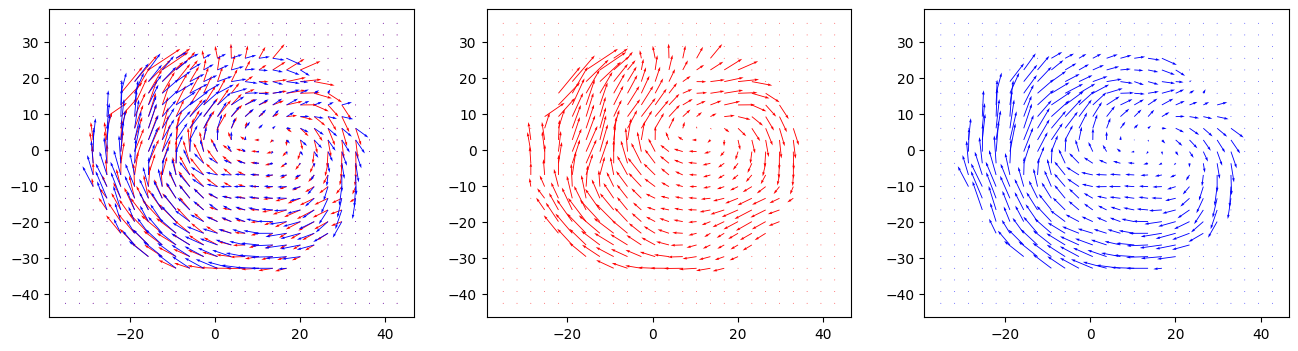

score:
-1.649167138349126
9


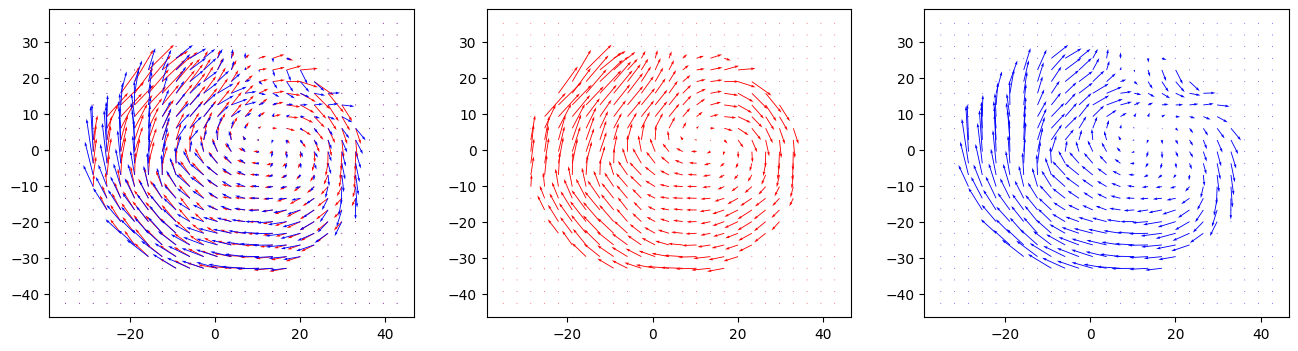

score:
-0.4825291248211254
10


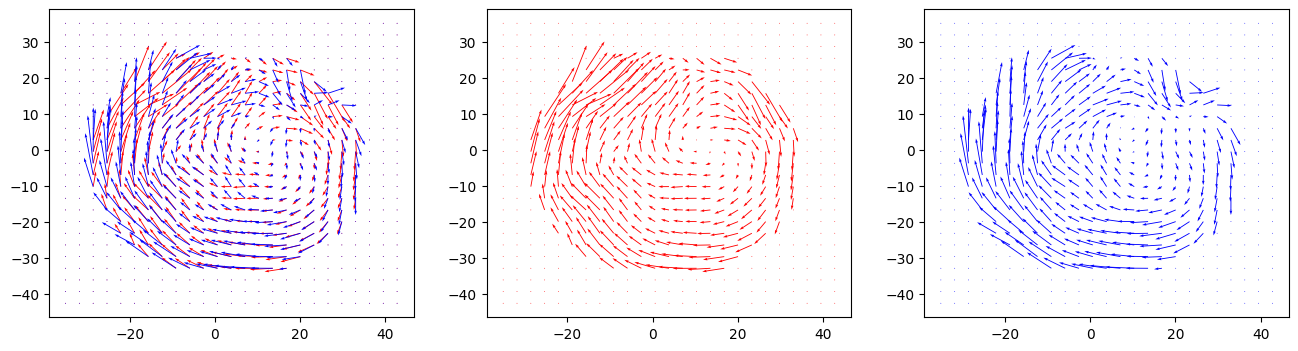

score:
-0.6693353009042884
11


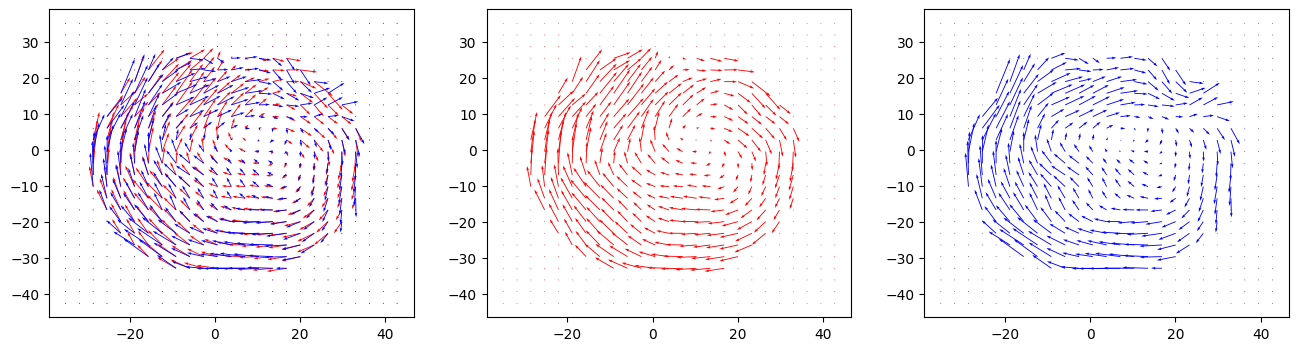

score:
-0.3081806199742563
12


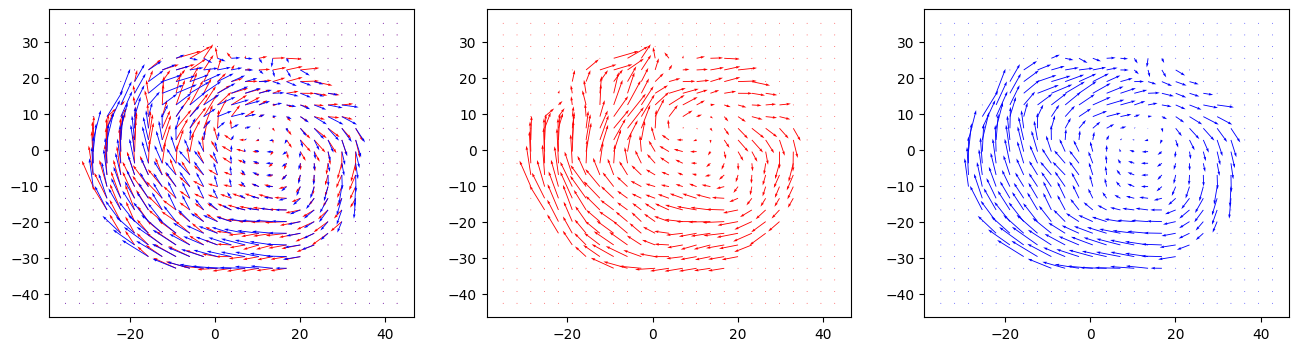

score:
-21.233159342488193
13


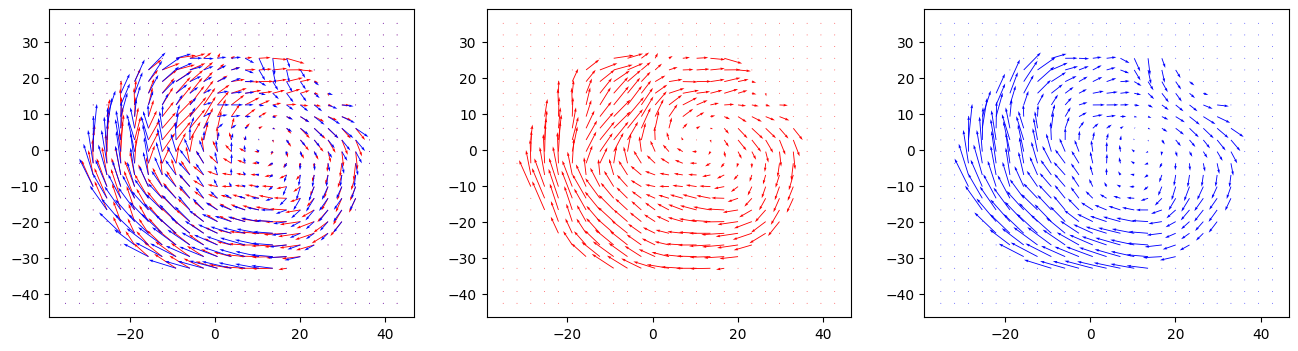

score:
-1.9924533708781154
14


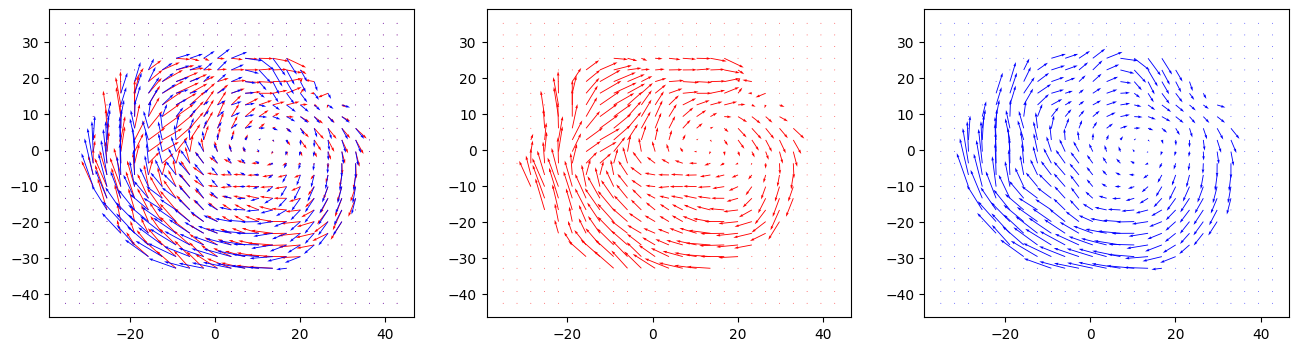

score:
-2.057776063770984
15


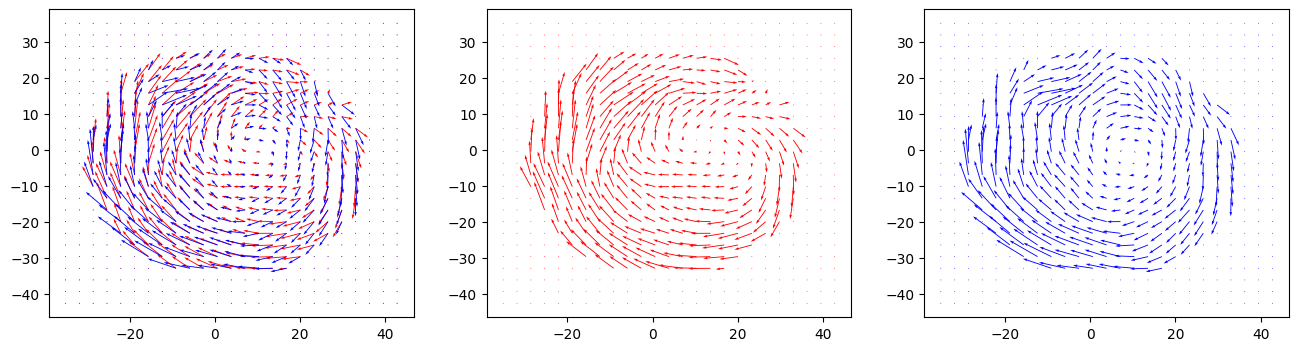

score:
-1.1177281535477215
16


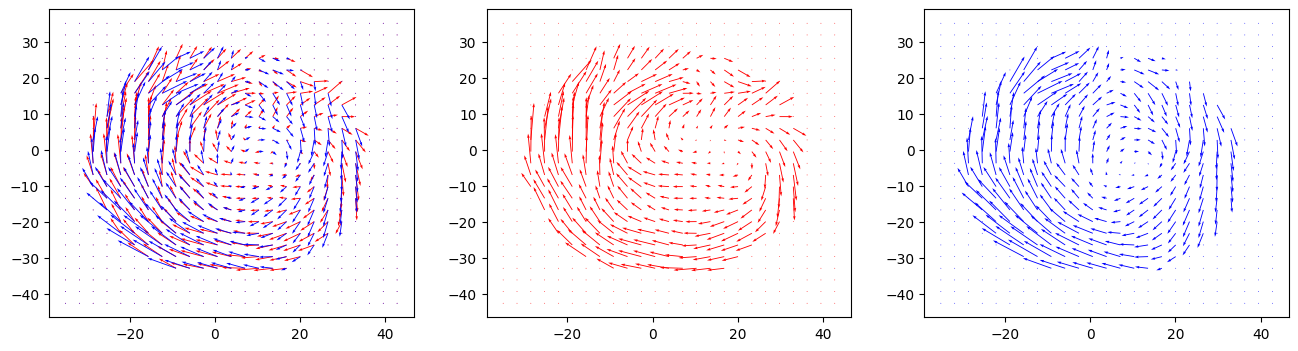

score:
-1.6024495112659651
17


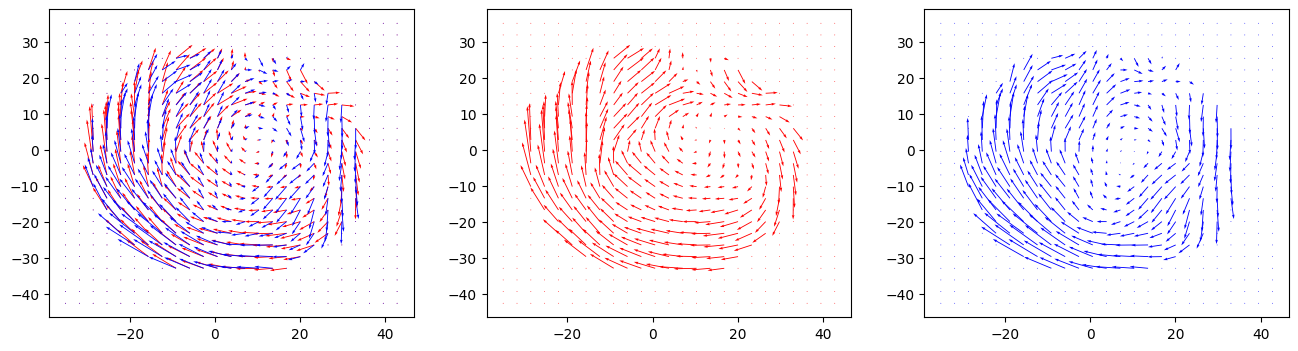

score:
-0.9145188571281461
18


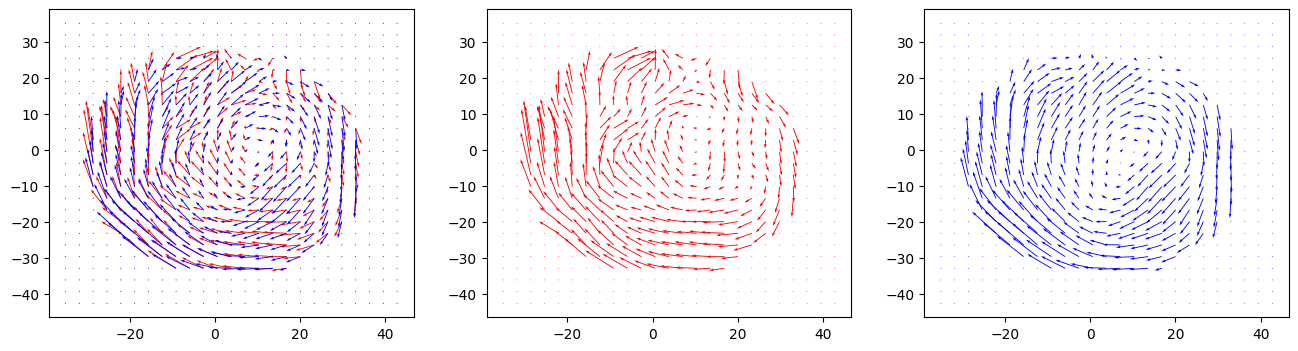

score:
-1.9891398618811797
19


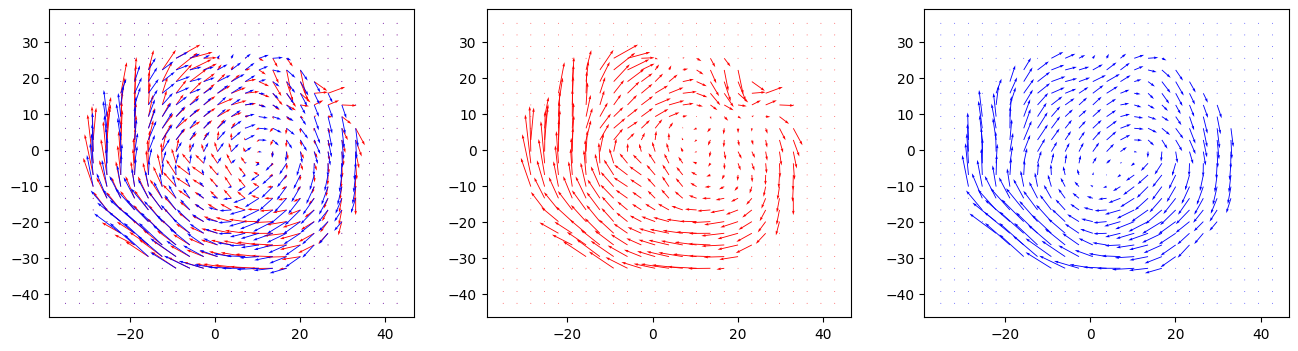

score:
-57.402787165636354
20


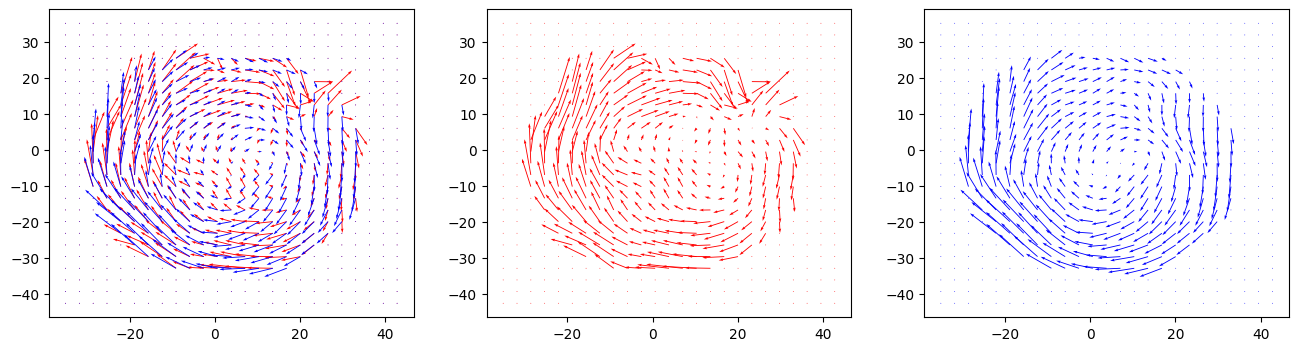

score:
-0.5382196047165266
21


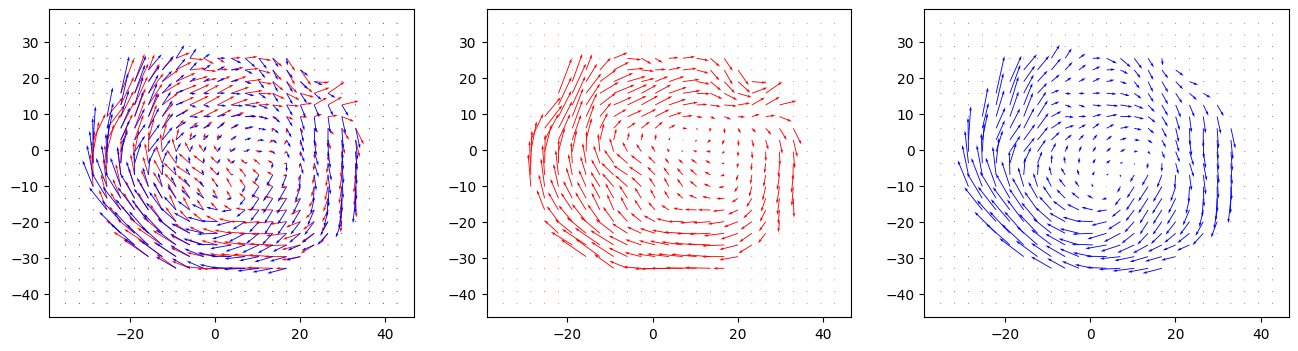

score:
-2.0008581227728115
22


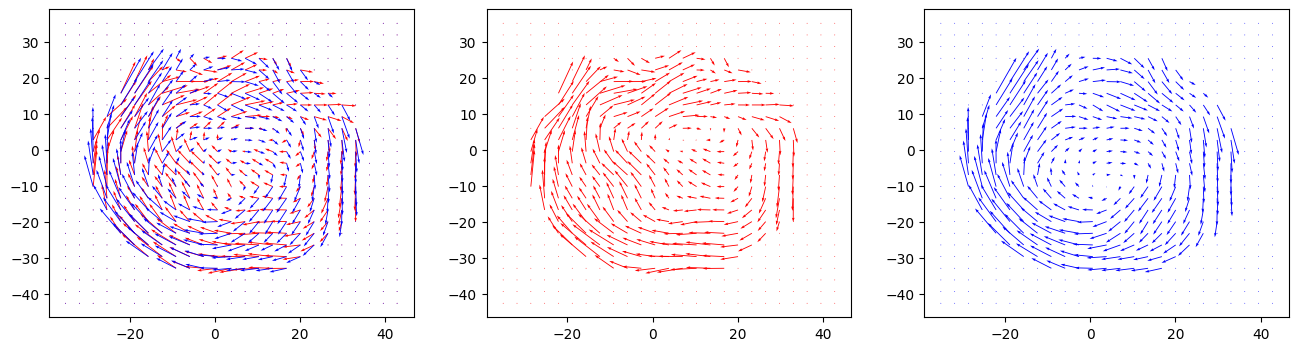

score:
-5.466159148133863
23


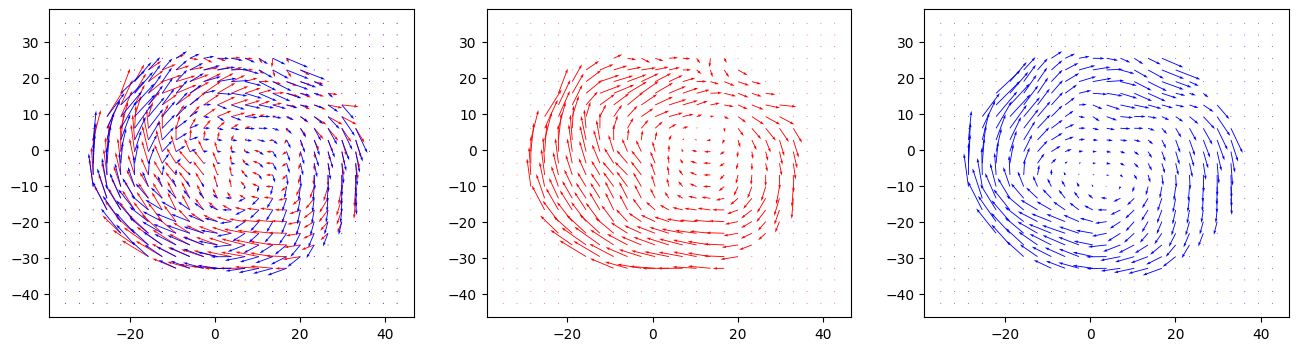

score:
-2.1224201468664043
24


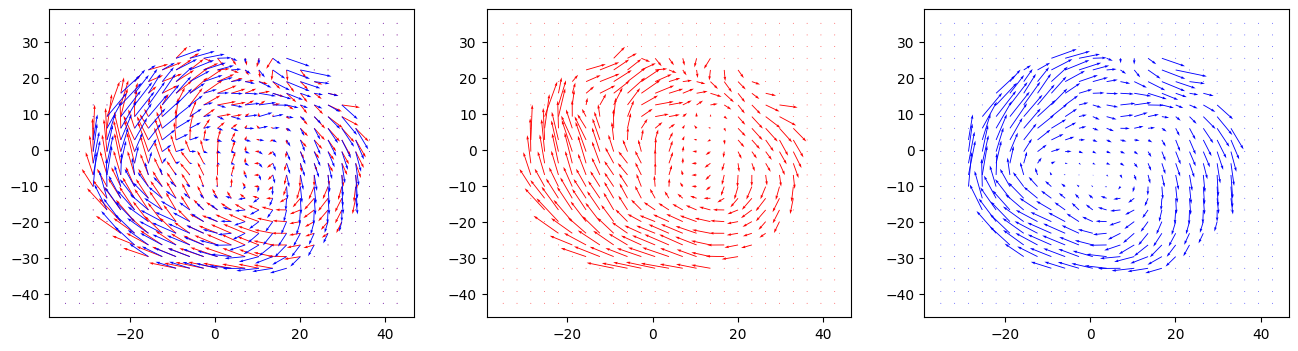

score:
-2.101805161360175
25


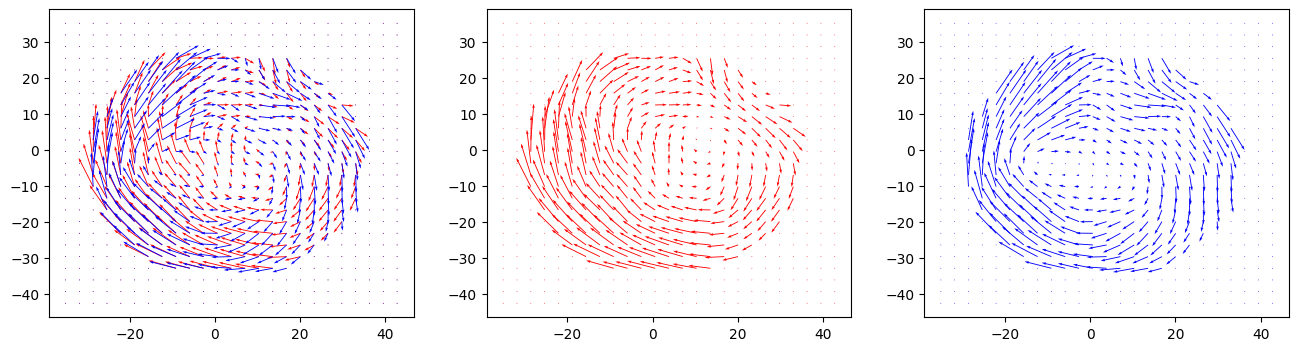

score:
-1.0193239994481513
26


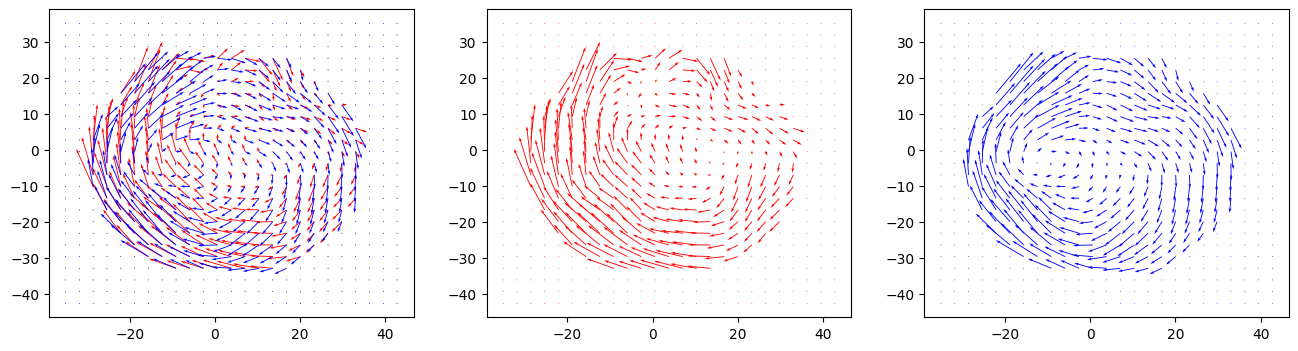

score:
-2.987856798091419
27


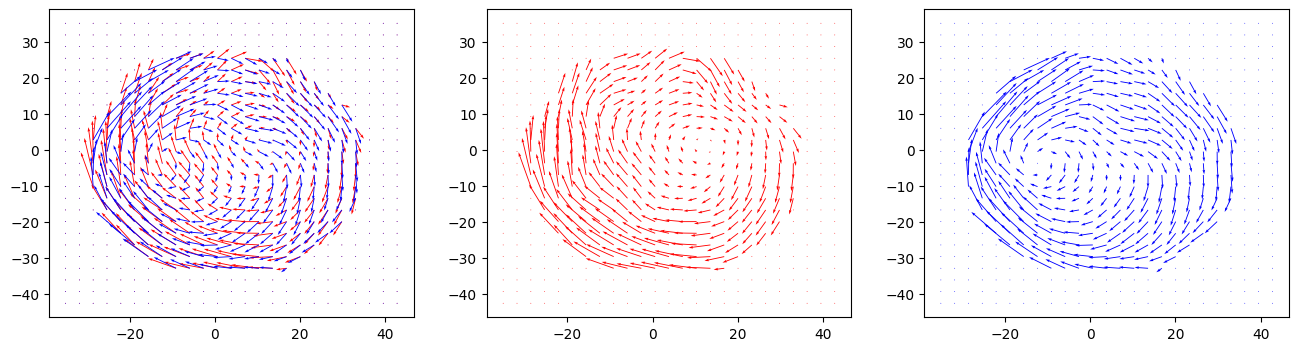

score:
-1.9755471625212317
28


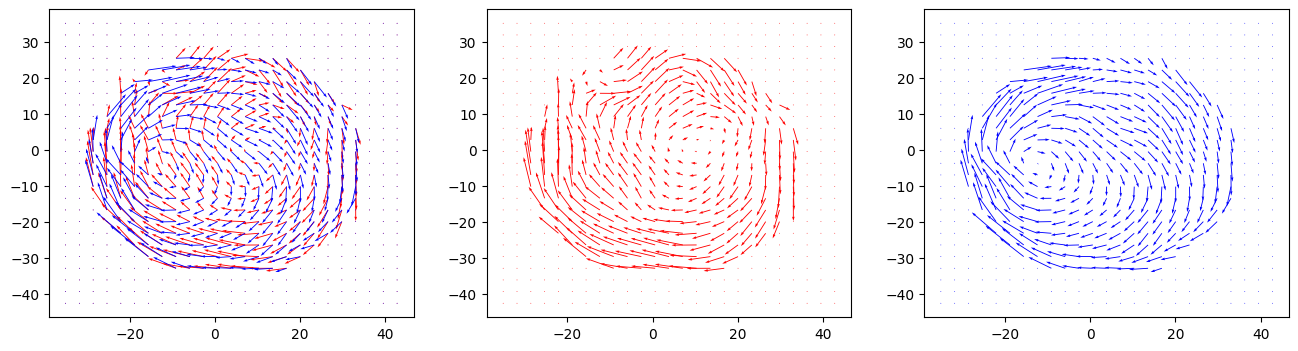

score:
-1.4368483127048133
29


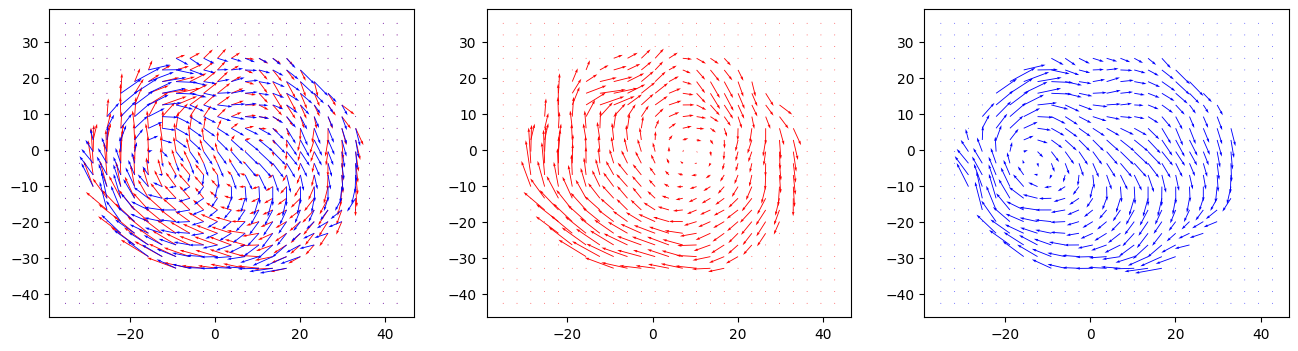

score:
-3.2084583913938967
30


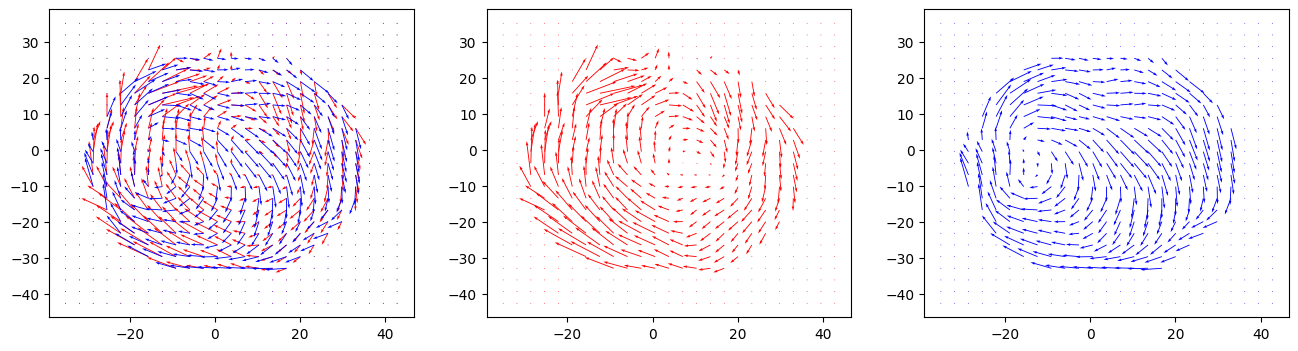

score:
-7.257558678815958
31


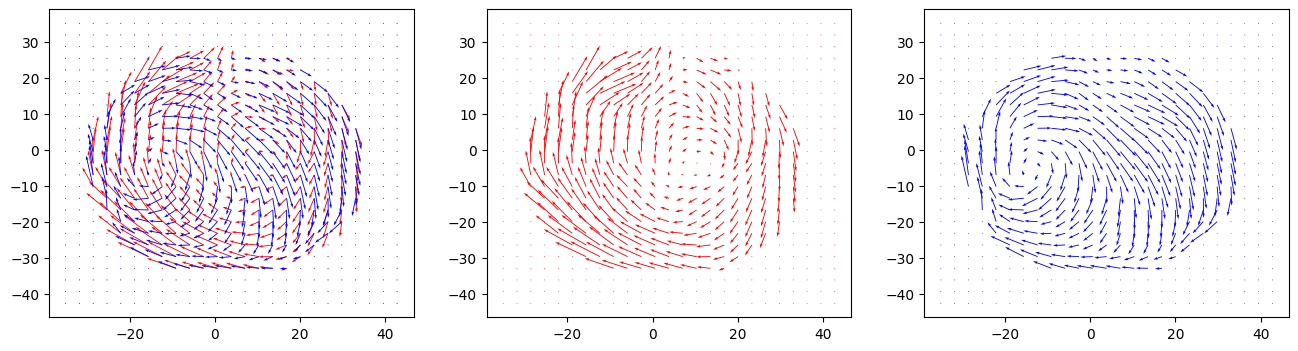

score:
-3.055065318180264
32


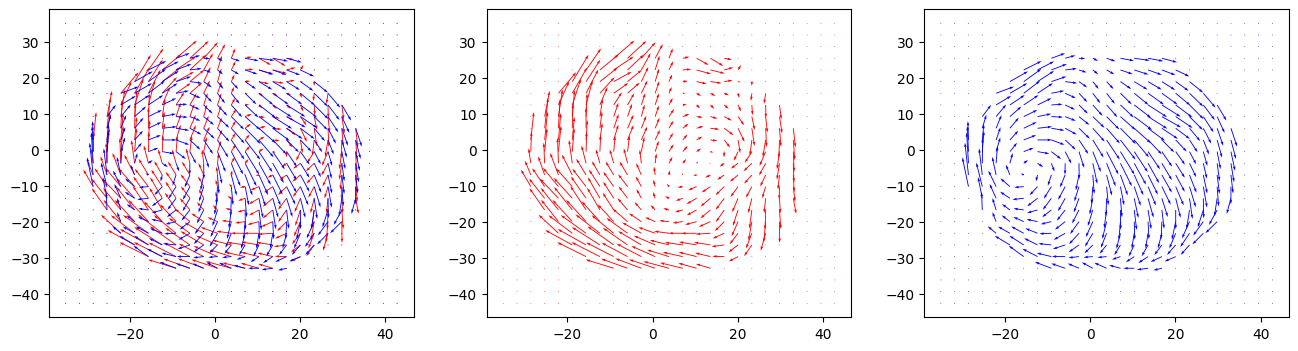

score:
-3.1676251489673084
33


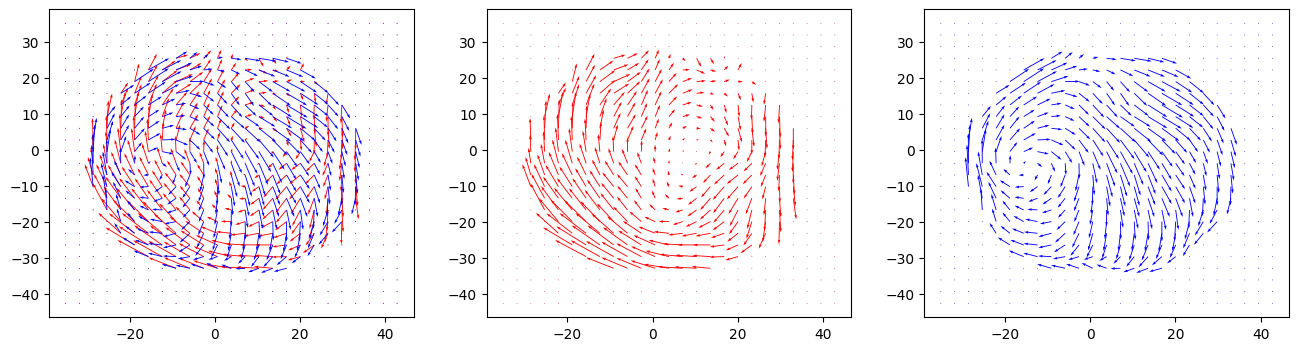

score:
-5.334027710320351
34


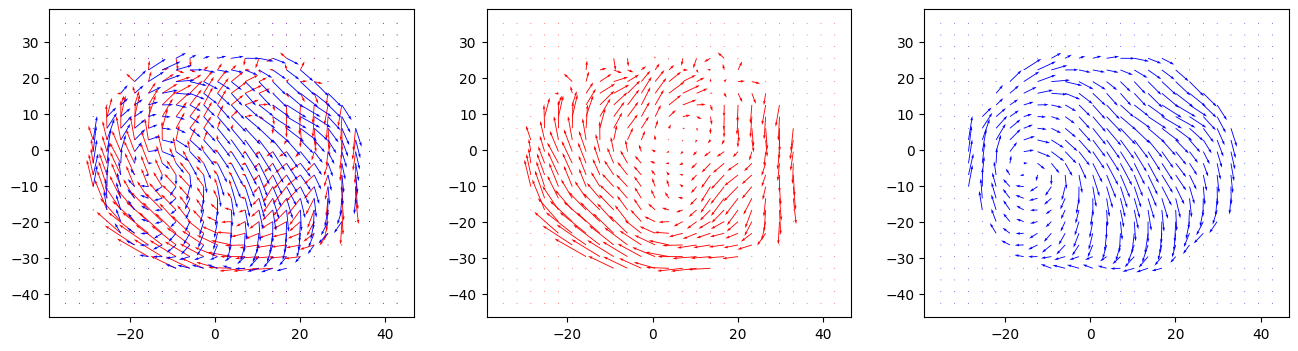

score:
-7.200888089409616
35


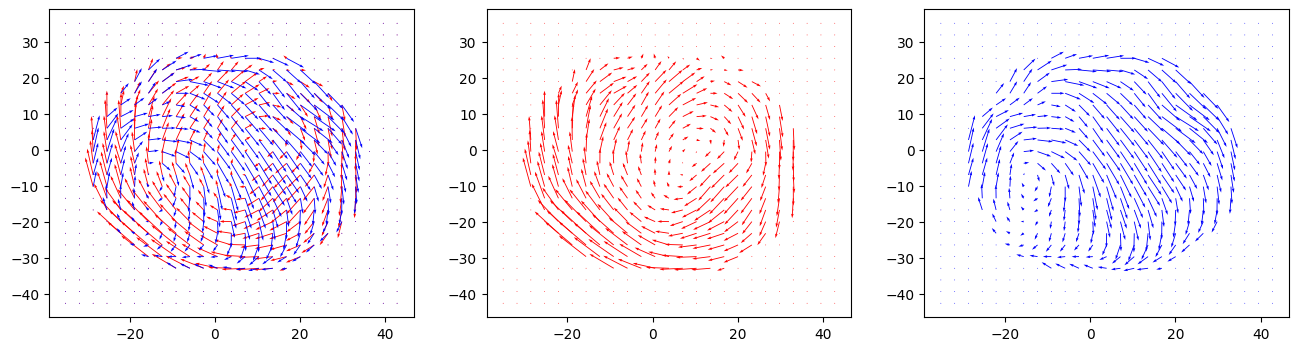

score:
-3.4986342315503824
36


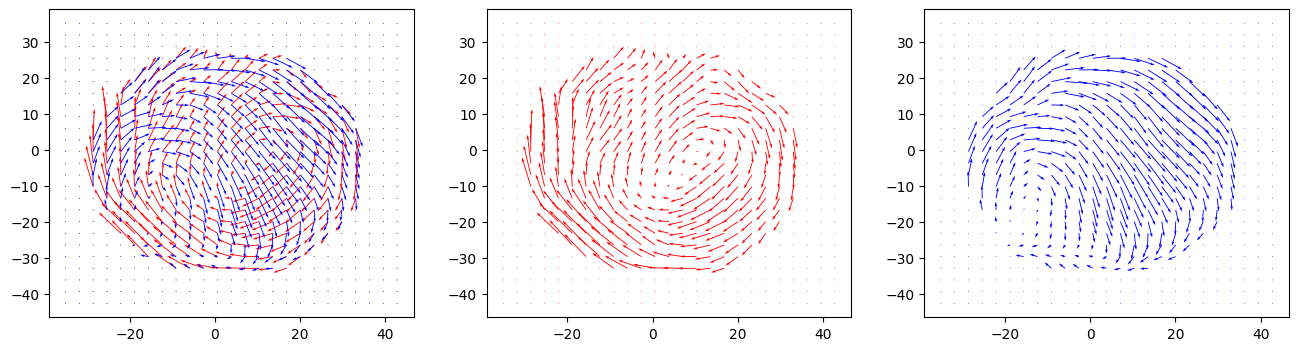

score:
-1.6921808800321143
37


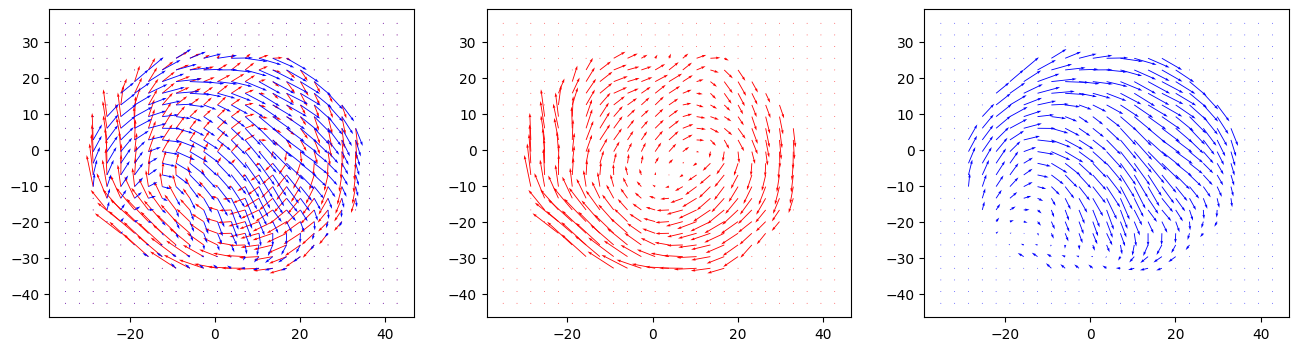

score:
-1.670571247291782
38


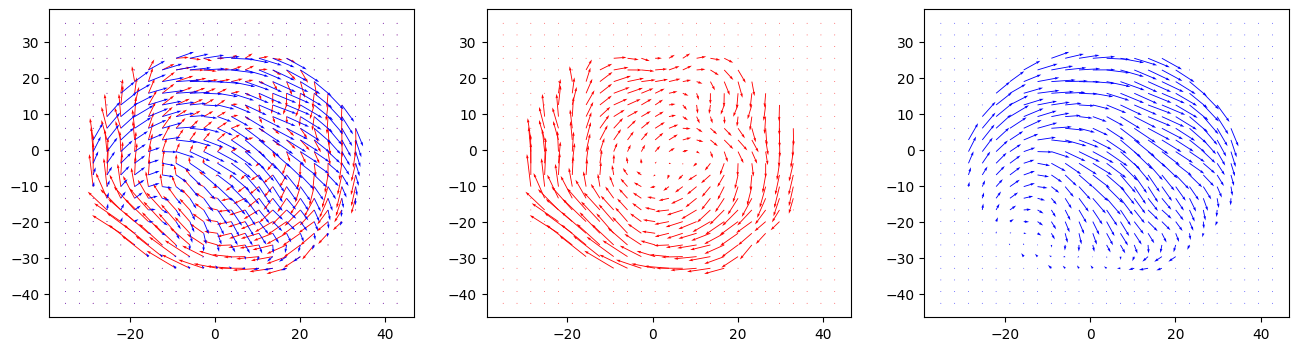

score:
-4.864852688830463
39


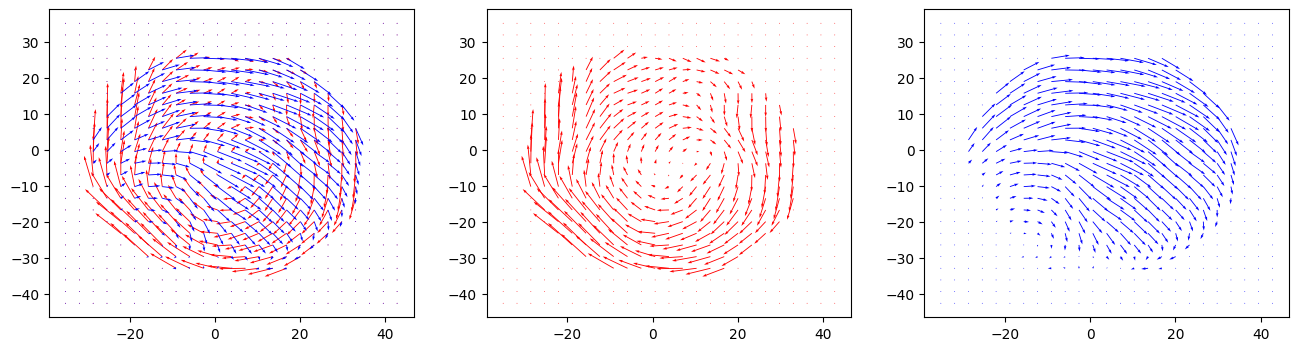

score:
-10.09006579647943


In [10]:
for i in range(40):
    print(i)
    j=i*2
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_train[:,:,i,0],v_train[:,:,i,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b')
    plt.subplot(1, 3, 2)
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_train[:,:,i,0],v_train[:,:,i,1],color='r')
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 3)
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
    plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b')
    plt.show()
    testscore(pltpredict[:,:,j,],v_train[:,:,i,:])